<h1>Document Similarity: FDR's Inaugural Addresses</h1>

Jared Neumann

<p>
For this project, I will compare the four inaugural addresses of Franklin Delano Roosevelt given in 1933, 1937, 1941, and 1945. I will rely on just a few packages, such as nltk and math, while using pandas for display purposes, and scipy only for the last part on hierarchical clustering.
</p>

<h6>Import Statements</h6>

In [4]:
import nltk, math
import pandas as pd
import scipy.cluster.hierarchy as sch

<p>
    First, we need to retrieve the documents that will be used for the project, namely, the four inaugural addresses, from the nltk corpora. This order corresponds to the indices [0-3] respectively in the results.
</p>

In [5]:
fdr_1933 = nltk.corpus.inaugural.raw('1933-Roosevelt.txt')
fdr_1937 = nltk.corpus.inaugural.raw('1937-Roosevelt.txt')
fdr_1941 = nltk.corpus.inaugural.raw('1941-Roosevelt.txt')
fdr_1945 = nltk.corpus.inaugural.raw('1945-Roosevelt.txt')

In [6]:
fdr_corpus_raw = [fdr_1933, fdr_1937, fdr_1941, fdr_1945]

<h3>Preprocessing</h3>

The next step is to clean up the texts. They will each be tokenized using the RegexpTokenizer in order to retain only alphanumeric characters (ignoring punctuation). All tokens will be made lowercase, stopwords (provided by nltk) will be removed, and words will be lemmatized. The results are added to a new list of the processed documents.

In [10]:
fdr_corpus_processed = []

#Use the RegexpTokenizer to retrieve alphumeric strings.
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

#Use the built-in stopwords list; this is not ideal, esp. considering the age of the texts.
stop_words = set(nltk.corpus.stopwords.words('english'))

#Use the built-in WordNetLemmatizer; there is some difficulty here due to spelling changes over the years.
lemmatizer = nltk.stem.WordNetLemmatizer()

#Put the aforementioned to use step-by step in each doc.
for doc in fdr_corpus_raw:
    doc_tokenized = tokenizer.tokenize(doc)
    doc_lowercase = [x.lower() for x in doc_tokenized] #List comprehension
    doc_nostopwords = [x for x in doc_lowercase if not x in stop_words]
    doc_lemmatized = [lemmatizer.lemmatize(x) for x in doc_nostopwords]
    
    #Append the result to the new list.
    fdr_corpus_processed.append(doc_lemmatized)

<h3>Function Definitions</h3>

Now, define a few functions that will be helpful later. Since we will be finding tf-idf values for the corpus, we will need a wordlist for the whole corpus and counts for the words in their respective documents. The approach taken here and for the other tf-idf functions was partially taken from <a href=https://github.com/mayank408/TFIDF>mayank408</a>.

In [9]:
def wordcounts(corpus):
    #Create a list for sets of words corresponding to each individual doc.
    docs_bow = []
    
    #Generate those sets and add them to the list.
    for doc in corpus:
        docs_bow.append(set(doc))

    #Create a general set of words for the whole corpus.
    corpus_bow = set.union(*docs_bow)

    #Create a list of dictionaries for wordcounts associated with each doc.
    word_dicts = [dict.fromkeys(corpus_bow, 0) for i in range(0, len(docs_bow))]

    #Count the number of occurrences of each word in the complete wordlist
    #for each document.
    for doc in corpus:
        for word in doc:
            word_dicts[corpus.index(doc)][word] += 1

    return word_dicts, docs_bow, corpus_bow

The next three definitions are for measuring tf-idf values for the words in the corpus. Term frequency (tf) is defined as the number of times a term (t) occurs in a document (d) divided by the total number of words (t', where t' &isin; d):
f<sub>t,d</sub> / &sum;f<sub>t',d</sub>.

In [14]:
def tf(word_dict, doc_bow):

    tf_dict = {}
    
    #this function only applies to one doc at a time, so we can just grab the wordcount from the doc that has been passed.
    wordcount = len(doc_bow)

    #update the dictionary with the tf math.
    for word, count in word_dict.items():
        tf_dict[word] = count/float(wordcount)

    return tf_dict

The Inverse Document Frequency (idf) is defined as the logarithm of the total number of documents (N) divided by the number of documents that contain a given term (df<sub>t</sub>): log(N / df<sub>t</sub>).

In [13]:
def idf(word_dicts):
    
    #word_dicts is our list of wordcounts in each doc.
    N = len(word_dicts)

    #initialize a dictionary with one of the wordlists in word_dicts.
    idf_dict = dict.fromkeys(word_dicts[0].keys(), 0)

    #update the count of the word if it appears in a doc.
    #only count it once per doc.
    for word_dict in word_dicts:
        for word, count in word_dict.items():
            if count > 0:
                idf_dict[word] += 1

    #update the count with the idf math
    for word, count in idf_dict.items():
        idf_dict[word] = math.log10(N/float(count))

    return idf_dict

Now, put the pieces together. Although, it should be noted that the idf scores must be calculated before the following function is useful, since they are one of the arguments. This function simply multiplies the two values together for each word. Again, this is meant to be used in a <i>for-loop</i> along with tf().

In [15]:
def tfidf(tf_dict, idf_scores):

    tfidf = {}

    #Update the dictionary with the values from our tf function multiplied by the scores from our idf function.
    for word, count in tf_dict.items():
        tfidf[word] = count * idf_scores[word]

    return tfidf

The last two remaining functions are to calculate different similarity metrics: cosine similarity and jaccard similarity. The former makes use of our tfidf scores, whereas the latter just needs the tokenized documents. Cosine similarity calculates the similarity between two vectors (e.g., the ones with the tfidf values corresponding to the words in each document) by taking the dot product of the two vectors and dividing it by their lengths multiplied together. Distance is obtained by subtracting the result from 1, which will be done <i>in situ</i> at execution.

In [30]:
def cos_sim(v_1, v_2):

    #definition of dot product
    dot_product = sum(a * b for a,b in zip(v_1, v_2))

    #definition of norm (length) of a vector
    norm_v1 = sum(a * a for a in v_1) ** 0.5
    norm_v2 = sum(b * b for b in v_2) ** 0.5

    #putting it together
    return dot_product/float(norm_v1 * norm_v2)

Jaccard similarity, on the other hand, calculates the similarity between two sets by taking their intersection and dividing it by their union.

In [19]:
def jacc_sim(v_1, v_2):

    #all the math takes place here, since we have already converted the documents to sets.
    return len(v_1.intersection(v_2))/float(len(v_1.union(v_2)))

<h3>Execution</h3>

First, grab the variables that will be needed by running wordcounts() and idf().

In [21]:
word_dicts, docs_bow, corpus_bow = wordcounts(fdr_corpus_processed)
idf_scores = idf(word_dicts)

Second, generate the tf-idf scores:

In [22]:
tfidf_scores = []
for word_dict in word_dicts:
    i = word_dicts.index(word_dict)
    tfidf_scores.append(tfidf(tf(word_dict, docs_bow[i]), idf_scores))

<h6>Tf-Idf Values Table:</h6>

In [26]:
print(pd.DataFrame(tfidf_scores))

   make     every  multiplied  suffering  individual   falsity  purpose  \
0   0.0  0.000840    0.001012   0.000000    0.000000  0.001012      0.0   
1   0.0  0.000875    0.000000   0.002109    0.001582  0.000000      0.0   
2   0.0  0.000921    0.000000   0.000000    0.000740  0.000000      0.0   
3   0.0  0.000000    0.000000   0.000000    0.000000  0.000000      0.0   

   disruption  assurance   carried  ...  mistrust      draw      ever  \
0    0.000000   0.002024  0.000000  ...  0.000000  0.000000  0.000000   
1    0.000000   0.000000  0.000000  ...  0.000000  0.001054  0.003163   
2    0.002959   0.000000  0.001479  ...  0.000000  0.000000  0.000000   
3    0.000000   0.000000  0.000000  ...  0.003056  0.000000  0.000000   

    primary     order  time  faithful    temple  permanently     light  
0  0.001012  0.001012   0.0  0.000506  0.001012     0.001012  0.000000  
1  0.000000  0.001582   0.0  0.000527  0.000527     0.000000  0.001054  
2  0.000000  0.000000   0.0  0.000000  

Third, extract the vectors needs to calculate similarities between each individual document.

In [27]:
tfidf_vectors = []
for score in tfidf_scores:
    tfidf_vectors.append(list(score.values()))

Fourth, calculate cosine similarity between all vectors and construct a matrix out of the results.

In [31]:
cos_sim_matrix = []
for i in tfidf_vectors:
    cos_sim_row = []
    for j in tfidf_vectors:
        cos_sim_row.append(cos_sim(i,j))
    cos_sim_matrix.append(cos_sim_row)

<h6>Cosine Similarity Matrix</h6>

In [32]:
print(pd.DataFrame(cos_sim_matrix))

          0         1         2         3
0  1.000000  0.097259  0.042982  0.022202
1  0.097259  1.000000  0.064447  0.054338
2  0.042982  0.064447  1.000000  0.028709
3  0.022202  0.054338  0.028709  1.000000


Fifth, calculate jaccard similarity between all vectors and construct another matrix.

In [33]:
jacc_sim_matrix = []
for i in docs_bow:
    jacc_sim_row = []
    for j in docs_bow:
        jacc_sim_row.append(jacc_sim(i,j))
    jacc_sim_matrix.append(jacc_sim_row)

<h6>Jaccard Similarity Matrix</h6>

In [34]:
print(pd.DataFrame(jacc_sim_matrix))

          0         1         2         3
0  1.000000  0.189796  0.147766  0.106145
1  0.189796  1.000000  0.182588  0.126100
2  0.147766  0.182588  1.000000  0.146110
3  0.106145  0.126100  0.146110  1.000000


<h6>Clustering</h6>

Now, in order to conduct hierearchical clustering, it is necessary to convert the cosine similarity matrix obtained above into a distance matrix. Recall that it is obtained by subtracting the similarity scores from 1.

In [35]:
cos_dist_matrix = []
for i in tfidf_vectors:
    cos_dist_row = []
    for j in tfidf_vectors:
        cos_dist_row.append(1-cos_sim(i,j))
    cos_dist_matrix.append(cos_dist_row)

Relying on SciPy, use ward linkage to conduct the clustering.

In [36]:
linkage = sch.linkage(cos_dist_matrix, method='ward')

<h6>Hierarchical Clustering Table</h6>

In [37]:
print(linkage)

[[0.         1.         1.2772527  2.        ]
 [2.         4.         1.3592457  3.        ]
 [3.         5.         1.38880722 4.        ]]


<h6>Dendrogram</h6>

And, finally, draw a dendrogram that shows the clusters.

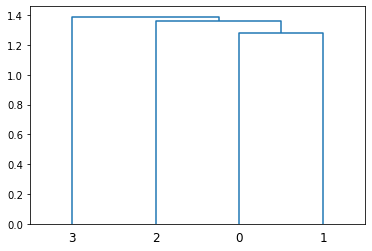

In [38]:
dendrogram = sch.dendrogram(linkage)

<h3>Conclusion</h3>

As I interpret the dendrogram, it would seem as though the first two of FDR's inaugural addresses are clustered together, and the last two do not have the same cohesion. It is interesting to not that the last address (3) is very short, so that may have made more appropriate clustering according to the given metrics difficult. There are some other limitations given the approach I have taken here. First, I decided to lemmatize rather than stem, but that choice was largely arbitrary. I do believe that tense might be an interesting rhetorical aspect that is overlooked by lemmatization. However, both the WordNetLemmatizer and the PorterStemmer could not manage the voocabulary in the texts, and I preferred the Lemmatizer on this qualitative measure. It would be interesting to compare the two overall, though. Finally, I hoped to uncover some trend in the addresses, but find it difficult to draw any firm conclusions. One that I think is supported by the evidence, at least, is that the content of the speeches seems to have changed successively. Might this mean that there is not a close correspondence between <i>first</i> inaugural addresses? Or that there is some kind of cohesion between terms in an administration? These are questions for a broader study.